# 8- MÉTRICAS

 La rápida expansión de NILM y el desarrollo de diferentes algoritmos, han hecho que sea esencial proporcionar una evaluación de rendimiento mediante el uso de métricas de desempeño. Las métricas de evaluación, comparan los resultados de la desagregaciónn (predicciones) de los modelos entrenados con los datos del set de validación (mediciones reales de cada proceso). NILMTK cuenta con el cálculo de métricas de evaluación mediante el uso del MeterGroup para la validación de los resultados mediante el set de validación 
 Vamos ahora analizar en nuestro dataset diferentes metricas como son FEAC,F1, EAE ,MNEAP y RMSE  que  resumimos a continuacion en el siguinte cuadro:

![metricas](metricas.jpg)

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

### Métricas individuales del modelo

In [2]:
#Librerías
from nilmtk.metrics import f1_score
from nilmtk.metrics import error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import fraction_energy_assigned_correctly

In [3]:



labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['Main', 'Fryer', 'LED Lamp',  'Incandescent lamp','Laptop Computer', 'Fan']})



 

#Set para validación
valid = DataSet('ualm2.h5')
valid.set_window(start="2023-02-24 17:40:01", end="2023-02-24 18:51:27")

valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)




#Datos de Dispositivos: predicción
# Se carga los resultados del mejor modelo
#dataset=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
#predictions=dataset.buildings[1].elec.submeters()   





index = list(labels['Meters'][1:6])
met = []
e = []



dataset=DataSet(data_dir+'NILM/Results/CO_60s_median_pred.h5')


predictions=dataset.buildings[1].elec.submeters()      

#Metricas
f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {};

f1['F1'] = f1_score(predictions, valid_Devices)

EAE = error_in_assigned_energy(predictions, valid_Devices)

for x in range(len(EAE)): e.append(EAE.iloc[x][0])
eae['EAE'] = e
#da error esta medida AttributeError: 'tuple' object has no attribute 'instance'
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                      pd.DataFrame(f1),
                      pd.DataFrame(eae, index=valid_Devices.instance()),
                      pd.DataFrame(mneap),
                      pd.DataFrame(rmse)],
                     axis=1).set_index(pd.Index(index)))

dataset.store.close()       
print('\n\nDone!')
metrics=met[0].transpose().round(3)
metrics

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)


Done!


,Fryer,LED Lamp,Incandescent lamp,Laptop Computer,Fan
F1,0.420,0.789,0.756,0.453,0.741
EAE,0.002,0.001,0.011,0.002,0.012
MNEAP,1.138,0.349,0.484,1.150,0.502
RMSE,17.417,7.339,22.688,13.816,12.651


Carga de datos de predicciones y GT en memoria

In [4]:
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})


labels = pd.DataFrame({'Instances': list(range(1,7)),'Meters': ['Main', 'Fryer', 'LED Lamp',  'Incandescent lamp','Laptop Computer','Fan']})
                       
Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]
    

    
    
#resultados de predicción modelo CO 30s

CO_60s_median=DataSet(data_dir+'NILM/Results/CO_60s_median_pred.h5')
elec_CO_60s_median=CO_60s_median.buildings[1].elec

#resultados de predicción modelo FHMM 30s

FHMM_60s_median=DataSet(data_dir+'NILM/Results/FHMM_60s_median_pred.h5')
elec_FHMM_60s_median=FHMM_60s_median.buildings[1].elec    
    
    

gt.columns=list(Meters.values())
pred_CO=elec_CO_60s_median.dataframe_of_meters(ac_type='active')

pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_60s_median.dataframe_of_meters(ac_type='active')

pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

### Análisis particular del cálculo de cada métrica

Metrica FEAC ( da problema con AttributeError: 'tuple' object has no attribute 'instance')

In [5]:
#Carga de datos de predicciones y GT en memoria
#gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
#gt.columns=list(Meters.values())

In [6]:
#predictions_Devices=elec_CO_60s_first.submeters()

#frac_1 = valid_Devices.fraction_per_meter()
#frac_2 = predictions_Devices.fraction_per_meter()
#fig, (ax1, ax2) = plt.subplots(1, 2 ,gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

#frac_1.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax1,   colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan'])
#frac_2.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',  labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax2,  colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']) 

#ax1.set(ylabel="")
#ax1.set(xlabel="GT")
#ax2.set(ylabel="")
#ax2.set(xlabel="Predictions")
#plt.savefig('./data/images/5.4_FEAC_CO_60s.svg', bbox_inches='tight', transparent=True)
#pass

## Métrica F1

Esta métrica mide la precisión o asertividad del modelo entrenado mediante el cálculo de la media armónica utilizando las métricas Precision y Recall. Estas métricas son calculadas internamente por NILMTK mediante la matriz de confusión, vease la ecuación de la figura siguiente.

![metricas](metricas.jpg)

Precision se entiende como la fracción de cortes de tiempo en los que se predijo correctamente que un proceso estaba activo, pero realmente se encontraba apagado. Por lo contrario, Recall hace referencia a la fracción de cortes de tiempo en los que se predijo correctamente que el dispositivo estaba encendido y realmente se encontraba encendido .

In [7]:
pd.DataFrame(metrics.loc['F1']).transpose()*100

,Fryer,LED Lamp,Incandescent lamp,Laptop Computer,Fan
F1,42.0,78.9,75.6,45.3,74.1


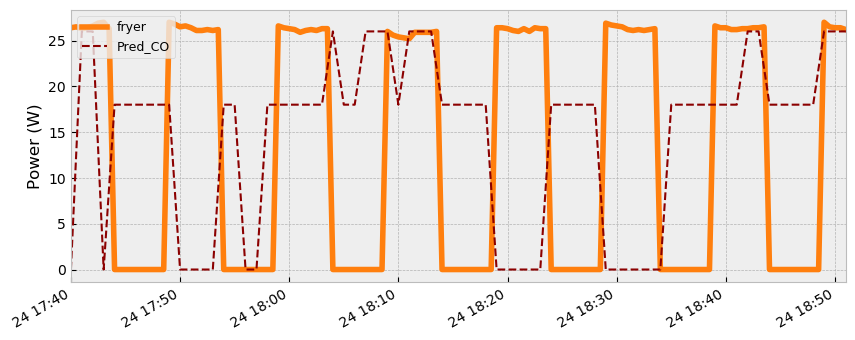

In [8]:
rcParams['figure.figsize'] = (10, 4)

fig, ax1 = plt.subplots();
ax1=gt['Fryer'].plot(lw=4, c='tab:orange')
pred_CO['Fryer'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['fryer','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylabel('Power (W)')

plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

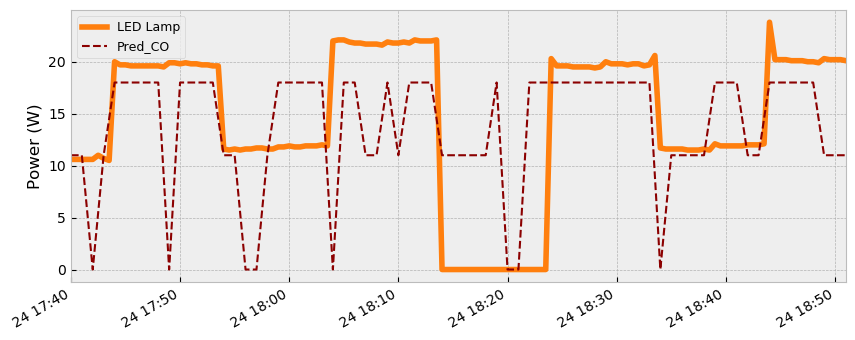

In [9]:
rcParams['figure.figsize'] = (10, 4)

fig, ax1 = plt.subplots();
ax1=gt['LED Lamp'].plot(lw=4, c='tab:orange')
pred_CO['LED Lamp'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['LED Lamp','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylabel('Power (W)')
#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

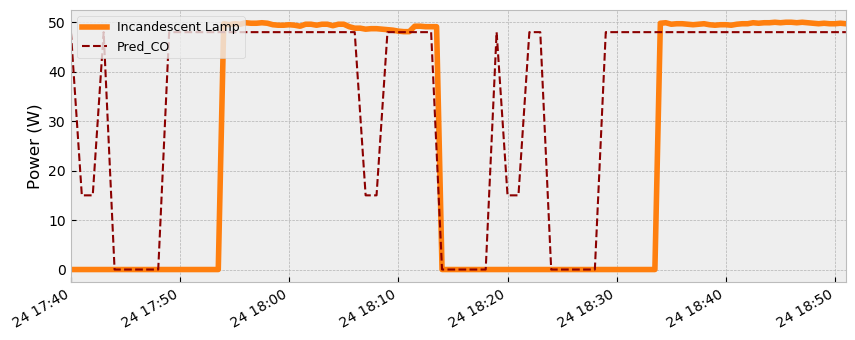

In [10]:
rcParams['figure.figsize'] = (10, 4)

fig, ax1 = plt.subplots();
ax1=gt['Incandescent lamp'].plot(lw=4, c='tab:orange')
pred_CO['Incandescent lamp'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Incandescent Lamp','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylabel('Power (W)')
#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

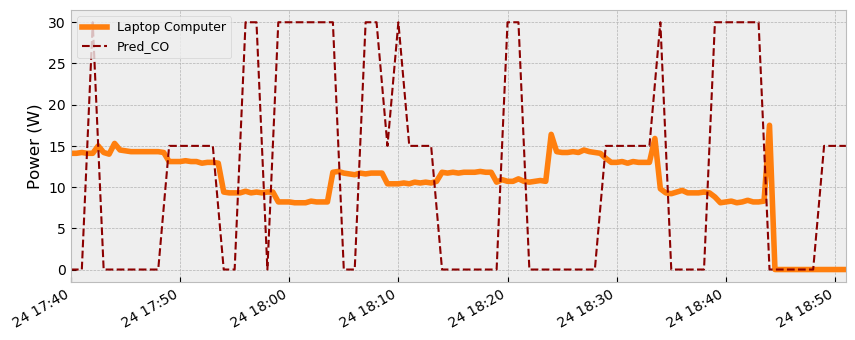

In [11]:
rcParams['figure.figsize'] = (10, 4)

fig, ax1 = plt.subplots();
ax1=gt['Laptop Computer'].plot(lw=4, c='tab:orange')
pred_CO['Laptop Computer'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Laptop Computer','Pred_CO'], fontsize=9, loc='upper left', ncol=1)

ax1.set_ylabel('Power (W)')
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

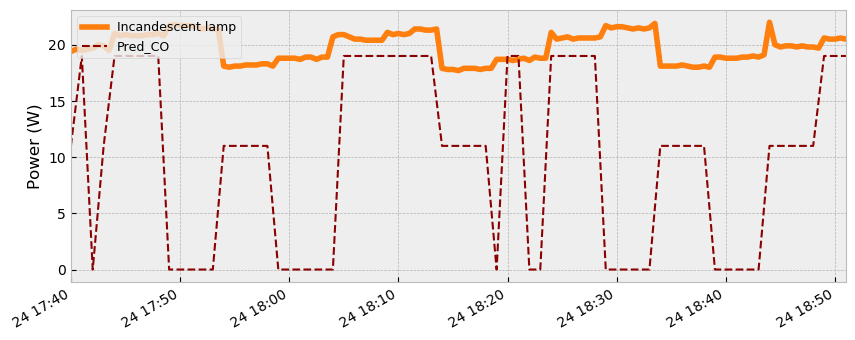

In [12]:
rcParams['figure.figsize'] = (10, 4)
fig, ax1 = plt.subplots();
ax1=gt['Fan'].plot(lw=4, c='tab:orange')
pred_CO['Fan'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Incandescent lamp','Pred_CO'], fontsize=9, loc='upper left', ncol=1)


ax1.set_ylabel('Power (W)')

plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

## Métrica EAE

La ecuación de la figura representa la diferencia entre la energía total asignada yˆt(n) energía total consumida yt(n) por el proceso n de la industria en kWh 

![metricas](metricas.jpg)

In [13]:
round(pd.DataFrame(metrics.loc['EAE']).transpose(),2)

,Fryer,LED Lamp,Incandescent lamp,Laptop Computer,Fan
EAE,0.0,0.0,0.01,0.0,0.01


In [14]:
predictions_Devices=elec_CO_60s_median.submeters()
e1=predictions_Devices[5].total_energy()[0]
e2=valid_Devices[5].total_energy()[0]
eae=round(abs(e1-e2),2)

pd.DataFrame([e1,e2,eae], columns=['kWh'], index=['Energy_pred','Energy_GT','EAE'])

,kWh
Energy_pred,0.014000
Energy_GT,0.012283
EAE,0.000000


## Métrica MNEAP

Este indicador que representa la ecuacion de la imagen  consta de la diferencia entre la potencia asignada yˆt(n) y la potencia real yt(n) de cada proceso de la industria, por cada intervalo de tiempo t. Después de sumar todas las diferencias de potencia, el resultado es normalizado por el consumo total de la energía del proceso 

![metricas](metricas.jpg)

In [15]:
round(pd.DataFrame(metrics.loc['MNEAP']).transpose(),2)

,Fryer,LED Lamp,Incandescent lamp,Laptop Computer,Fan
MNEAP,1.14,0.35,0.48,1.15,0.5


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


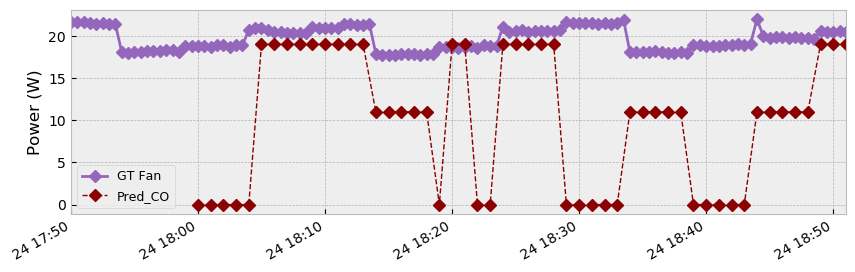

In [16]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['Fan'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['Fan'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT Fan','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['Fan'][a1[0]:a1[1]]-pred_CO['Fan'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1



#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


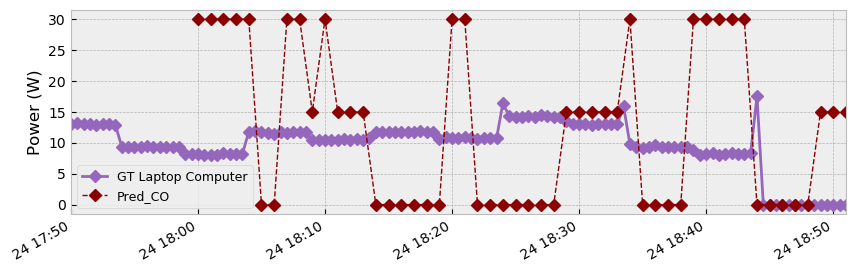

In [17]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['Laptop Computer'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['Laptop Computer'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT Laptop Computer','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['Laptop Computer'][a1[0]:a1[1]]-pred_CO['Laptop Computer'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1



#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


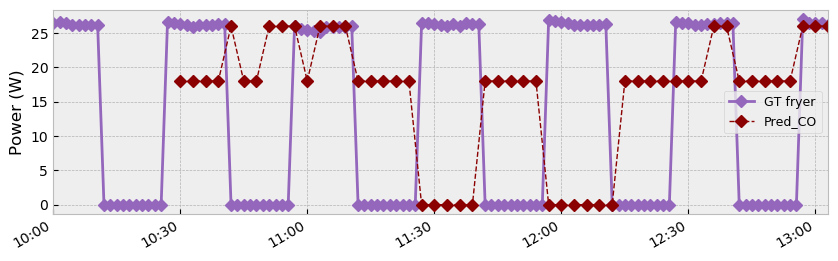

In [18]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['Fryer'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['Fryer'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT fryer','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['Fryer'][a1[0]:a1[1]]-pred_CO['Fryer'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 130+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


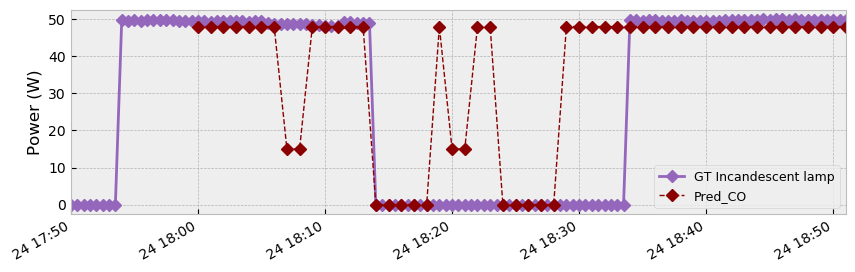

In [19]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['Incandescent lamp'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['Incandescent lamp'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT Incandescent lamp','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['Incandescent lamp'][a1[0]:a1[1]]-pred_CO['Incandescent lamp'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


  
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


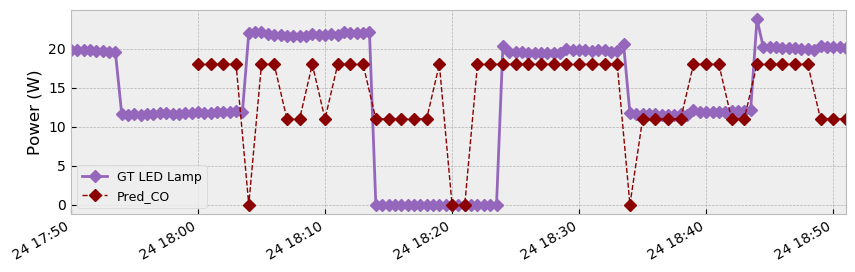

In [20]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['LED Lamp'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['LED Lamp'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT LED Lamp','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['LED Lamp'][a1[0]:a1[1]]-pred_CO['LED Lamp'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


 
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

## Métrica RMSE

Esta métrica de la ecuación de la figura es muy utilizada en la comparaciónn de diversos conjuntos de datos, consiste en el error cuadrático medio de la diferencia entre la potencia asignada yˆt(n) y la potencia real yt(n) del proceso de los applicativos , en cada intervalo de tiempo t .

![metricas](metricas.jpg)

In [21]:
round(pd.DataFrame(metrics.loc['RMSE']).transpose(),1)

,Fryer,LED Lamp,Incandescent lamp,Laptop Computer,Fan
RMSE,17.4,7.3,22.7,13.8,12.7


## Resultados de todos los modelos

In [22]:
from nilmtk.metrics import fraction_energy_assigned_correctly, f1_score, error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power, rms_error_power 
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10} #, '15min':60*15, '30min':60*30}

dir_predictions = data_dir +'NILM/Results/'
m = {}
classifiers = ['CO', 'FHMM']
methods = ['first', 'mean', 'median']
index = list(labels['Meters'][1:7])

for p_name, sp in periods.items():
    met = []
    for method in methods:
        for clf_name in classifiers:
            print('\nCalculando Metricas: '+ clf_name + '_' + p_name + '_' + method)  
           
            #Datos de Dispositivos: predicción
            input_dir = dir_predictions + clf_name + '_' + p_name + '_' + method +'_pred.h5'
            dataset = DataSet(input_dir)
            predictions=dataset.buildings[1].elec.submeters()       
            
            #Metricas
            f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {}; e=[];  
            F1 = f1_score(predictions, valid_Devices)
            f1['F1'] = F1*100
            EAE = error_in_assigned_energy(predictions, valid_Devices)
            
            for x in range(len(EAE)): e.append(EAE.iloc[x][0])
            eae['EAE'] = e
            #da error para FEAC
            #feac['FEAC'] = 100*np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
            mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
            rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
            met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                                  pd.DataFrame(f1),
                                  pd.DataFrame(eae, index=valid_Devices.instance()),
                                  pd.DataFrame(mneap),
                                  pd.DataFrame(rmse)],
                                 axis=1).set_index(pd.Index(index)))
            dataset.store.close()        
    m[p_name] = met

##Guardamos resultados
f = open(data_dir +'NILM/metrics.txt',"w")
f.write( str(m) )
f.close()
print('\n\nDone!')



Calculando Metricas: CO_10s_first

Calculando Metricas: FHMM_10s_first

Calculando Metricas: CO_10s_mean

Calculando Metricas: FHMM_10s_mean

Calculando Metricas: CO_10s_median

Calculando Metricas: FHMM_10s_median

Calculando Metricas: CO_30s_first

Calculando Metricas: FHMM_30s_first

Calculando Metricas: CO_30s_mean

Calculando Metricas: FHMM_30s_mean

Calculando Metricas: CO_30s_median

Calculando Metricas: FHMM_30s_median

Calculando Metricas: CO_60s_first

Calculando Metricas: FHMM_60s_first

Calculando Metricas: CO_60s_mean

Calculando Metricas: FHMM_60s_mean

Calculando Metricas: CO_60s_median

Calculando Metricas: FHMM_60s_median

Calculando Metricas: CO_5min_first

Calculando Metricas: FHMM_5min_first

Calculando Metricas: CO_5min_mean

Calculando Metricas: FHMM_5min_mean

Calculando Metricas: CO_5min_median

Calculando Metricas: FHMM_5min_median

Calculando Metricas: CO_10min_first

Calculando Metricas: FHMM_10min_first

Calculando Metricas: CO_10min_mean

Calculando Metric

## Otras Metricas: métricas Promedio

In [23]:
m_mean = {}

#cols=['FEAC','F1','EAE','MNEAP','RMSE']

cols=['F1','EAE','MNEAP','RMSE']
labels=['CO-first', 'CO-mean', 'CO-median', 'FHMM-first', 'FHMM-mean' ,'FHMM-median']
per=['10s','30s','60s','5min','10min'] #,'15min','30min']

for c in cols:
    m_mean[c] = pd.DataFrame([#CO FIRST
                             [m['10s'][0][c].mean(),m['30s'][0][c].mean(),m['60s'][0][c].mean(),
                              m['5min'][0][c].mean(),m['10min'][0][c].mean()],
                            #  m['15min'][0][c].mean(),m['30min'][0][c].mean()],
                              #CO MEAN
                             [m['10s'][2][c].mean(),m['30s'][2][c].mean(),m['60s'][2][c].mean(),
                              m['5min'][2][c].mean(),m['10min'][2][c].mean()],
                              #m['15min'][2][c].mean(),m['30min'][2][c].mean()],
                              #CO MEDIAN
                             [m['10s'][4][c].mean(),m['30s'][4][c].mean(),m['60s'][4][c].mean(),
                              m['5min'][4][c].mean(),m['10min'][4][c].mean()],
                              #m['15min'][4][c].mean(),m['30min'][4][c].mean()],
                             #FHMM FIRST
                             [m['10s'][1][c].mean(),m['30s'][1][c].mean(),m['60s'][1][c].mean(),
                             m['5min'][1][c].mean(),m['10min'][1][c].mean()],
                             # m['15min'][1][c].mean(),m['30min'][1][c].mean()],
                             #FHMM MEAN            
                             [m['10s'][3][c].mean(),m['30s'][3][c].mean(),m['60s'][3][c].mean(),
                              m['5min'][3][c].mean(),m['10min'][3][c].mean()],
                              #m['15min'][3][c].mean(),m['30min'][3][c].mean()],
                             #FHMM MEDIAN
                             [m['10s'][5][c].mean(),m['30s'][5][c].mean(),m['60s'][5][c].mean(),
                              m['5min'][5][c].mean(),m['10min'][5][c].mean()]],columns=per, index=labels).transpose()
                             # m['15min'][5][c].mean(),m['30min'][5][c].mean()]],
                              
m_mean


{'F1':         CO-first    CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s    75.243233  76.344218  75.866203   72.789120  72.656615    63.613193
 30s    72.745803  71.686967  71.673752   68.926765  68.547529    68.997192
 60s    63.431515  64.996651  63.177128   60.988986  65.369718    63.684522
 5min    0.000000   0.000000   0.000000   13.888889  13.888889    13.888889
 10min   0.000000   0.000000   0.000000    5.000000   5.000000     5.000000,
 'EAE':        CO-first  CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s    0.005270      0.0        0.0         0.0        0.0          0.0
 30s    0.000000      0.0        0.0         0.0        0.0          0.0
 60s    0.000000      0.0        0.0         0.0        0.0          0.0
 5min   0.019382      0.0        0.0         0.0        0.0          0.0
 10min  0.000000      0.0        0.0         0.0        0.0          0.0,
 'MNEAP':        CO-first   CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s    

## Maximos


In [24]:
cols=['F1','EAE','MNEAP','RMSE']

maxs=pd.concat([m_mean['F1'].transpose().max(),
                m_mean['EAE'].transpose().min(),
                m_mean['MNEAP'].transpose().min(),
                m_mean['RMSE'].transpose().min()], axis=1)
maxs.columns=cols
maxs = maxs.transpose()
round(maxs,2)

,10s,30s,60s,5min,10min
F1,76.34,72.75,65.37,13.89,5.00
EAE,0.00,0.00,0.00,0.00,0.00
MNEAP,0.67,0.70,0.68,0.74,0.57
RMSE,13.04,14.49,14.78,14.28,11.34


## Correspondencia de Indice

In [25]:
cols=['F1','EAE','MNEAP','RMSE']

maxs_i=pd.concat([m_mean['F1'].transpose().idxmax(),
                 m_mean['EAE'].transpose().idxmin(),
                 m_mean['MNEAP'].transpose().idxmin(),
                 m_mean['RMSE'].transpose().idxmin()], axis=1)
maxs_i.columns=cols
maxs_i = maxs_i.transpose()
maxs_i

,10s,30s,60s,5min,10min
F1,CO-mean,CO-first,FHMM-mean,FHMM-first,FHMM-first
EAE,CO-mean,CO-first,CO-first,CO-mean,CO-first
MNEAP,CO-mean,CO-first,FHMM-mean,FHMM-first,FHMM-first
RMSE,CO-mean,CO-first,CO-mean,FHMM-first,FHMM-first


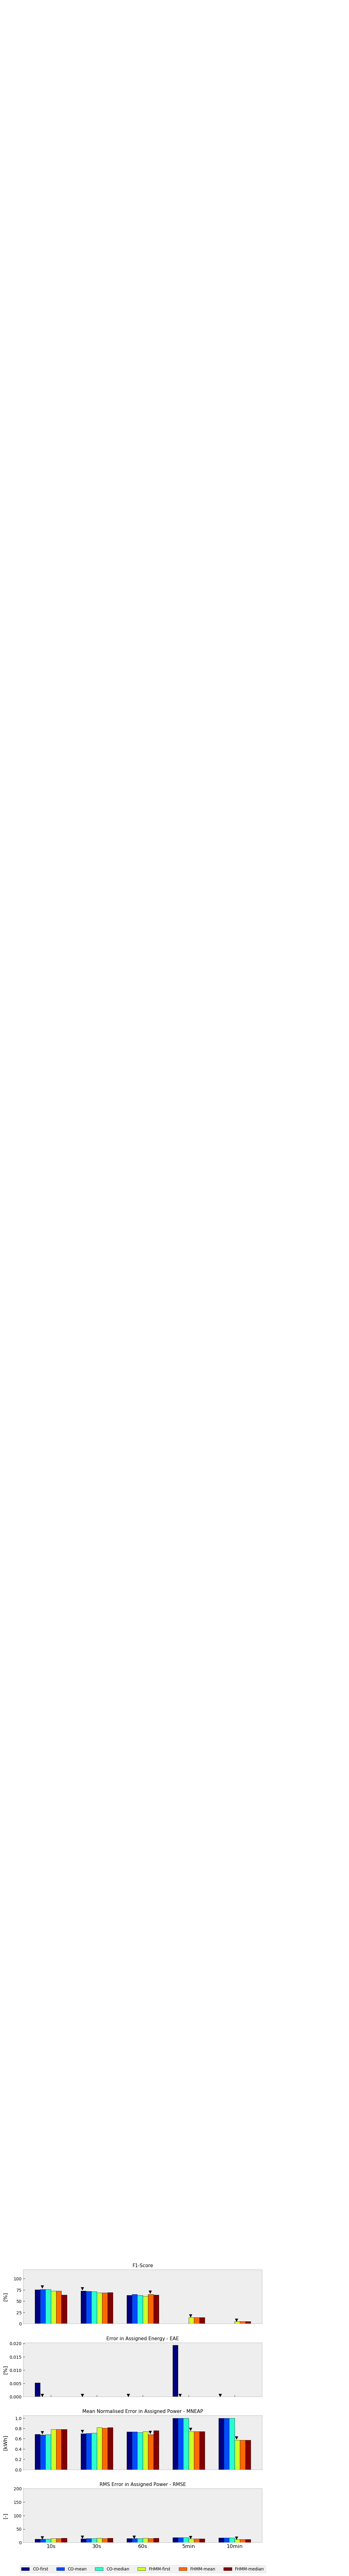

In [26]:
rcParams['figure.figsize'] = (10, 11.5)
fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0.35})
cols=['F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
per=['10s','30s','60s','5min','10min'] # ,'15min','30min']

labels={'CO-first':-0.35, 'CO-mean':-0.22, 'CO-median':-0.11, 'FHMM-first':0.01, 'FHMM-mean':0.13 ,'FHMM-median':0.245}

c=0
for ax in fig.get_axes():      
    m_mean[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, cmap="jet")
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    x = 0
    for p in per:
        ax.annotate("▼", xy=(labels[maxs_i[p][cols[c]]]+x, maxs[p][cols[c]]+maxs[p][cols[c]]*0.03))
        x+=1
    c+=1
    
ax5.set_xticklabels(labels=per, rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax2,ax3,ax4,ax5)])
ax2.set(ylim=(0,120))
ax2.set_yticks([0,25,50,75,100])

ax5.set_yticks([0,50,100,150,200])

ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels.keys(), loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.6),fontsize=9.5)


#ax2.annotate("90.5%", xy=(0.68, 98)); #30s FHMM-mean
#ax3.annotate("0.19", xy=(6.22, 1.4)); #30min FHMM-median
ax3.annotate("kWh", xy=(6.22, 0.9)); #30min FHMM-median
#ax4.annotate("0.24", xy=(6.22, 0.7)); #30min FHMM-median
#ax5.annotate("41.5", xy=(6.22, 120)); #30min FHMM-median
ax5.annotate("   W", xy=(6.22, 90)); #30min FHMM-median


plt.savefig('./data/images/5.7_All_metrics.svg', bbox_inches='tight', transparent=True)

pass

In [27]:
print('FHMM-first')
print(m['30s'][1])
print('\nFHMM-mean')
print(m['30s'][3])
print('\nFHMM-median')
print(m['30s'][5])

FHMM-first
                          F1  EAE     MNEAP       RMSE
Fryer              63.736264  0.0  0.836495  16.357420
LED Lamp           76.991150  0.0  0.623026  10.629197
Incandescent lamp  79.104478  0.0  0.388289  21.491051
Laptop Computer    62.801932  0.0  1.705811  18.111343
Fan                62.000000  0.0  0.533235  13.690894

FHMM-mean
                          F1  EAE     MNEAP       RMSE
Fryer              67.052023  0.0  0.715534  15.055000
LED Lamp           69.523810  0.0  0.690773  12.084146
Incandescent lamp  86.713287  0.0  0.268644  17.491502
Laptop Computer    69.724771  0.0  1.698797  18.054960
Fan                49.723757  0.0  0.656631  15.427432

FHMM-median
                          F1  EAE     MNEAP       RMSE
Fryer              64.088398  0.0  0.830106  16.326393
LED Lamp           76.991150  0.0  0.623026  10.629197
Incandescent lamp  79.104478  0.0  0.388289  21.491051
Laptop Computer    62.801932  0.0  1.705811  18.111343
Fan                62.000000  

### Resultados del mejor modelo
En vista de los resultados del obtenidos, se propone la elección del modelo FHMM entrenado con datos promedio de dispositivos cada 30 segundos. Este modelo solo se considera adecuado para la desagregación de datos promedio de potencia activa medidos en cabecera cada 30 segundos.

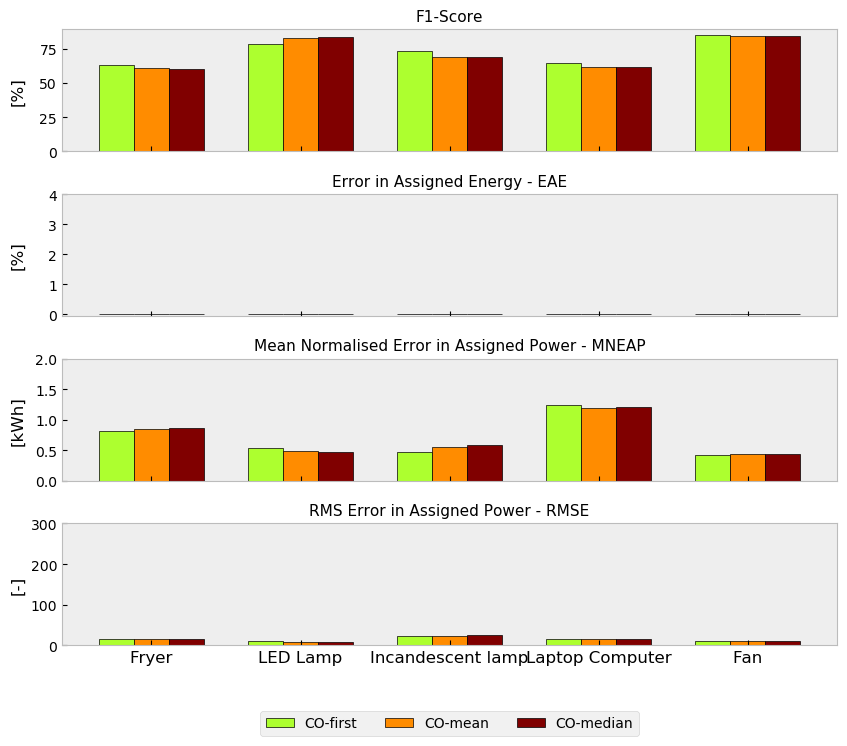

In [28]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=False, gridspec_kw={'hspace': 0.35})

#cols=['FEAC','F1','EAE','MNEAP','RMSE']
cols=['F1','EAE','MNEAP','RMSE']

ylabels=['[%]','[%]','[kWh]','[-]','[W]']

#labels=['FHMM-first', 'FHMM-mean' ,'FHMM-median']

labels=['CO-first', 'CO-mean' ,'CO-median']

c=0

for ax in fig.get_axes():
    #FHMM
  #  df=pd.DataFrame([m['30s'][1][cols[c]],m['30s'][3][cols[c]],m['30s'][5][cols[c]]]).transpose()
    #CO
    df=pd.DataFrame([m['30s'][0][cols[c]],m['30s'][2][cols[c]],m['30s'][4][cols[c]]]).transpose()
  
    #if ax==ax1:
    #    df['FEAC'].mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
    #else:
    #     df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
 
    df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1   
    

ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax3.set_yticks([0,1,2,3,4])
ax4.set(ylim=(0,1.8))
ax4.set_yticks([0,0.5,1,1.5,2])
ax5.set(ylim=(0,270))
ax5.set_yticks([0,100,200,300])
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))


plt.savefig('./data/images/5.8_All_metrics_2.svg', bbox_inches='tight', transparent=True)

pass

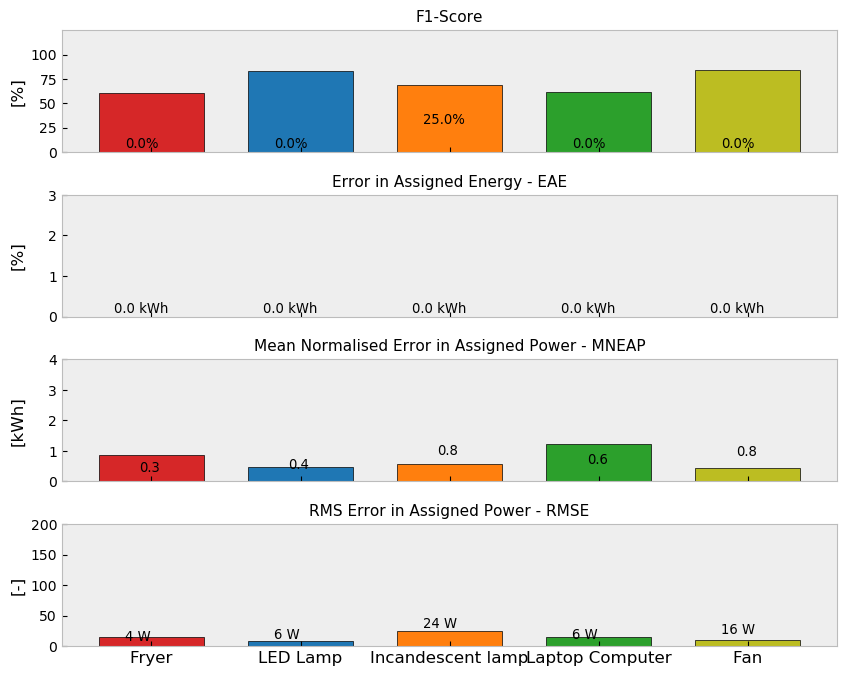

In [29]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=False, gridspec_kw={'hspace': 0.35})
#cols=['FEAC','F1','EAE','MNEAP','RMSE']

cols=['F1','EAE','MNEAP','RMSE']

ylabels=['[%]','[%]','[kWh]','[-]','[W]']
colors=['tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0

for ax in fig.get_axes():
    df=pd.DataFrame(m['30s'][4][cols[c]])
    df[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=colors)
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1


ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})

fig.align_ylabels([(ax2,ax3,ax4,ax5)])

ax2.set(ylim=(0,125))
ax3.set(ylim=(0,1))
ax4.set(ylim=(0,0.7))
ax5.set(ylim=(0,110))

ax2.set_yticks([0,25,50,75,100])
ax3.set_yticks([0,1,2,3])
ax4.set_yticks([0,1,2,3,4])
ax5.set_yticks([0,50,100,150,200])


ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')

df=pd.DataFrame(m['10min'][5])

for x in range(5):ax2.annotate(str(round(df['F1'][x],1))+'%', xy=(x-0.18 , df['F1'][x]+4),fontsize=9.5)
for x in range(5):ax3.annotate(str(round(df['EAE'][x],1))+' kWh', xy=(x-0.25 , df['EAE'][x]+0.1),fontsize=9.5)
for x in range(5):ax4.annotate(str(round(df['MNEAP'][x],1)), xy=(x-0.08 , df['MNEAP'][x]+0.03),fontsize=9.5)
for x in range(5):ax5.annotate(str(round(df['RMSE'][x]))+' W', xy=(x-0.18 , df['RMSE'][x]+5),fontsize=9.5)

plt.savefig('./data/images/5.9_Metrics_FHMM_30min_median.svg', bbox_inches='tight', transparent=True)

In [30]:
valid_Devices.total_energy()

Calculating total_energy for ElecMeterID(instance=6, building=1, dataset='DSUAL') ...   

active    0.099792
dtype: float64

In [31]:
valid_Devices.energy_per_meter()

5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])nstance=1)])])

,"(2, 1, DSUAL)","(3, 1, DSUAL)","(4, 1, DSUAL)","(5, 1, DSUAL)","(6, 1, DSUAL)"
active,0.015834,0.017322,0.03087,0.012283,0.023483
apparent,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN


### Replicando el entrenamiento del modelo

In [32]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import CombinatorialOptimisation

train = DataSet('ualm2.h5')


train.set_window(start="2023-05-11 14:49:22", end="2023-05-11 16:19:09")



train_elec=train.buildings[1].elec 

#dispositivos a entrenar: [Lights_1, Lights_2, HVAC_1, HVAC_2, HVAC_4, Rack]
train_Devices=train_elec.select(instance=[2,3,4,5,6])

#opcional: asignación manual de estados de dispositivos
num_states={train_Devices[2]:2, train_Devices[3]:3, train_Devices[4]:4,
            train_Devices[5]:5, train_Devices[6]:6}

#entrenamiento y exportación del modelo
CO_60s_median=CombinatorialOptimisation()
CO_60s_median.MIN_CHUNK_LENGTH=1
CO_60s_median.train(train_Devices,
                        num_states_dict={}, #en otro caso: { }
                        ac_type='active',
                        sample_period=1800,
                        resample_kwargs={'how':'median'})




print('\n\nDone!')


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!


Done!


In [33]:
CO_60s_median.model

[{'states': array([0]),
  'training_metadata': ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])},
 {'states': array([0]),
  'training_metadata': ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])},
 {'states': array([0]),
  'training_metadata': ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])},
 {'states': array([0]),
  'training_metadata': ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])},
 {'states': array([0]),
  'training_metadata': ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])}]